# Here we run some of the previous tests but with nested subspaces
Starting with the usual ground-truth $u_h$!

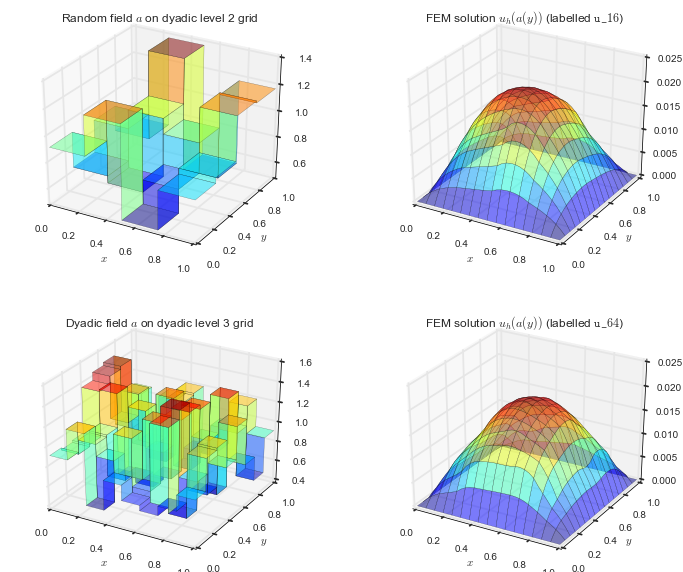

In [2]:
import numpy as np
import importlib
import dyadic_fem as df
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
importlib.reload(df)
%matplotlib inline

fem_div = 5

a_16 = df.make_dyadic_random_field(div=2, a_bar=1.0, c=0.5, seed=1)
fem_16 = df.DyadicFEMSolver(div=fem_div, rand_field=a_16, f=1.0)
fem_16.solve()

a_64 = df.make_dyadic_random_field(div=3, a_bar=1.0, c=0.5, seed=1)
fem_64 = df.DyadicFEMSolver(div=fem_div, rand_field=a_64, f=1.0)
fem_64.solve()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(2, 2, 1, projection='3d')
a_16.plot(ax, title='Random field $a$ on dyadic level 2 grid')
ax = fig.add_subplot(2, 2, 2, projection='3d')
fem_16.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_16}$)')
ax = fig.add_subplot(2, 2, 3, projection='3d')
a_64.plot(ax, title='Dyadic field $a$ on dyadic level 3 grid')
ax = fig.add_subplot(2, 2, 4, projection='3d')
fem_64.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_64}$)')
plt.show()

### We test the nested spaces, which here is simply done by first creating ambient spaces $W_{\mathrm{big}}$ and $V_{\mathrm{big}}$ from which we pluck subspaces $W_m$ and $V_n$

In [36]:
# local_width is the width of the measurement squares
local_width = 2**(fem_div - 4)
ms = (25, 50, 100, 150, 200)
m_stats = np.zeros([2, len(ms)])

# We make the ambient spaces for Wm and Vn
Wbig = df.make_random_local_integration_basis(m=ms[-1], div=fem_div, width=local_width, space='H1')
Wbig = Wbig.orthonormalise()
Vbig, V_fields = df.make_reduced_basis(n=ms[-1], field_div=3, fem_div=fem_div, space='H1')
Vbig = Vbig.orthonormalise()

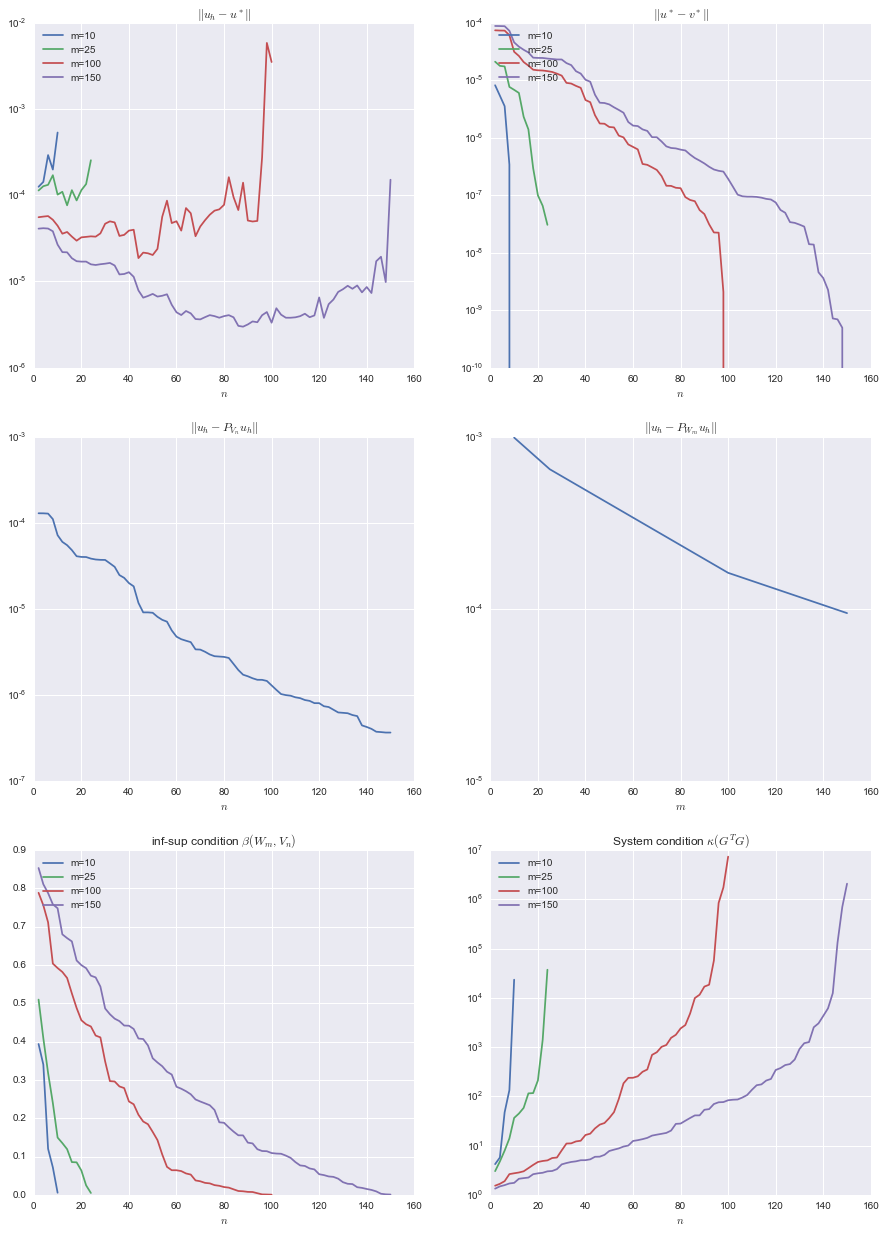

In [31]:
axs = []
fig = plt.figure(figsize=(15, 21))
axs.append(fig.add_subplot(3, 2, 1, title='$\| u_h - u^* \|$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 2, title='$\| u^* - v^* \|$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 3, title='$\| u_h - P_{V_n} u_h \|$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 4, title='$\| u_h - P_{W_m} u_h \|$'))
axs[-1].set(yscale="log", xlabel='$m$')
axs.append(fig.add_subplot(3, 2, 5, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 6, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')

for j, m in enumerate(ms):
    
    # If *not* nested use this code here:
    #Wm = df.make_random_local_integration_basis(m=m, div=fem_div, width=local_width, space='H1')
    #Wm = Wm.orthonormalise()
    
    Wm = Wbig.subspace(slice(0,m))
    
    # This is the measurement vector
    w = Wm.dot(fem_64.u)
    u_p_w = Wm.project(fem_64.u)

    m_stats[0, j] = (fem_64.u-u_p_w).norm(space='H1')
    
    ns = range(2, m+1, 2)
    stats = np.zeros([5, len(ns)])
    for i, n in enumerate(ns):
    
        Vn = Vbig.subspace(slice(0,n))
        # If *not* nested use this code here:
        #Vn, V_fields = df.make_reduced_basis(n=n, field_div=2, fem_div=fem_div, space='H1')
        #Vn = Vn.orthonormalise()
        
        u_p_v = Vn.project(fem_64.u)
        
        BP = df.BasisPair(Wm, Vn)
        FB = BP.make_favorable_basis()
        
        u_star, v_star, w_p, v_w_p = FB.measure_and_reconstruct(fem_64.u)
        
        stats[0, i] = (fem_64.u-u_star).norm(space='H1')
        stats[1, i] = (u_star - v_star).norm(space='H1')
        stats[2, i] = FB.beta()
        stats[3, i] = np.linalg.cond(BP.G.T @ BP.G)
        stats[4, i] = (fem_64.u - u_p_v).norm(space='H1')
        
    axs[0].plot(ns, stats[0,:], label='m={0}'.format(m))
    axs[0].legend(loc=2)
    axs[1].plot(ns, stats[1,:], label='m={0}'.format(m))
    axs[1].legend(loc=2)
    axs[4].plot(ns, stats[2,:], label='m={0}'.format(m))
    axs[4].legend(loc=2)
    axs[5].plot(ns, stats[3,:], label='m={0}'.format(m))
    axs[5].legend(loc=2)

axs[2].plot(ns, stats[4,:], label='m={0}'.format(m))
axs[3].plot(ms, m_stats[0,:], label='m={0}'.format(m))
    
plt.show()

### Now we look at the problem proposed by Giovanni
We have a dyadic level-1 field, i.e. $y\in\mathbb{R}^4$. We take $\bar{a} = 0.1$, $c=0.05$, $f=4.0$

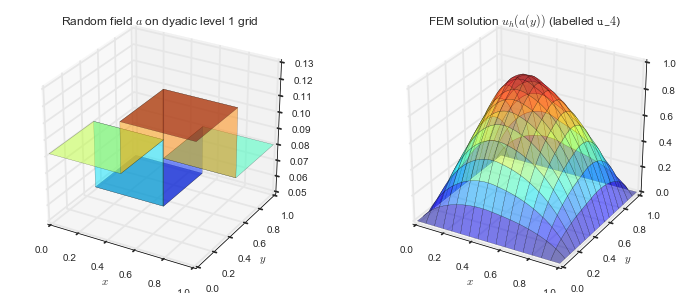

In [9]:
fem_div = 6

#rand_values = 0.1 + 0.05 * np.array([[0.5, 0.7], [-0.8, 0.3]])
#a_4 = df.DyadicPWConstant(rand_values)
a_4 = df.make_dyadic_random_field(div=1, a_bar=0.1, c=0.05, seed=1)
fem_4 = df.DyadicFEMSolver(div=fem_div, rand_field=a_4, f=4.0)
fem_4.solve()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
a_4.plot(ax, title='Random field $a$ on dyadic level 1 grid')
ax = fig.add_subplot(1, 2, 2, projection='3d')
fem_4.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_4}$)')
plt.show()


Note that for the level 1 dyadic field, i.e. where $y\in \mathbb{R}^4$, the largest we can take $n$, the rank of $V_n$, is about $n=18$, if we plan to orthonormalise $V_n$. 

I have consistently found that if $n>18$ then the $v_i$ become very close to linearly dependent. See 3_two_by_two.ipynb notebook for a test of this.

In [10]:
import math
# local_width is the width of the measurement squares
local_width = math.ceil(0.05 * 2**(fem_div))
print(2**(-fem_div), local_width)

ms = (100,)
m_stats = np.zeros([2, len(ms)])

# We make the ambient spaces for Wm and Vn
Wbig = df.make_random_local_integration_basis(m=ms[-1], div=fem_div, width=local_width, space='H1')
Wbig = Wbig.orthonormalise()
Vbig, V_fields = df.make_reduced_basis(n=18, field_div=1, fem_div=fem_div, space='H1', a_bar=0.1, c=0.05, f=4.0)
Vbig = Vbig.orthonormalise()

0.015625 4


### Test and inspect the projections on the first few elements, to make sure we're not totally off with our results 
We look at the small case $V_1 = \{v_1\}$ and $V_2 = \{v_1, v_2\}$. Also 

...Lets just test the first few projections to make sure we're in the right ball-park. In the case of $V_1 = \{v_1\}$, we should have that $v^* = c v_1$ where $c = \left( \sum_i \langle \omega_i, v_1 \rangle \langle\omega_i, u \rangle  / \sum_i \langle \omega_i, v_1 \rangle^2\right)$. We compare $c$ with $\langle v_1, u\rangle$, and look at a few plots

$v^*$ and $P_{V_1} u = \langle v_1, u \rangle v_1$ should be pretty close to each other, and $\| u - u^* \|_{H_0^1}$ should be in the same ball-park as $\| u - v^* \|_{H_0^1}$ and $\| u - P_{V_1} u \|_{H_0^1}$.

c = 2.3616648763210293, <v_1, u> = 2.345425946786945
|| v* - c v_1 || = 3.583389649283948e-32 (should be 0 within machine tol.)
|| u - v* || = 0.1516668466050309
|| u - P_V u || = 0.15140314377261802
|| u - u* || = 0.10125810605303798


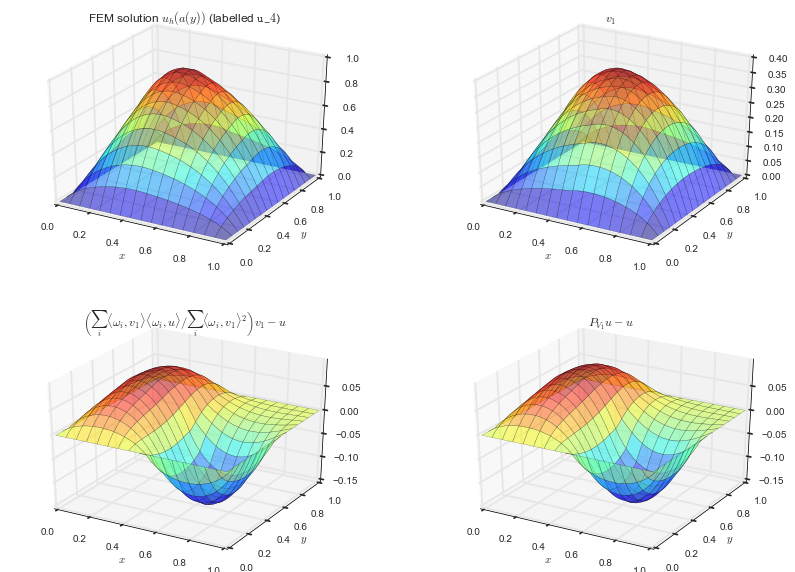

In [40]:
Wm = Wbig.subspace(slice(0,10))
Vn = Vbig.subspace(slice(0,1))
u_p_v = Vn.project(fem_4.u)

u_star, v_star, w_p, v_w_p, cond = df.optimal_reconstruction(Wm, Vn, Wm.dot(fem_4.u))

amount = (Wm.vecs[0] * fem_4.u.dot(Wm.vecs[0]) - fem_4.u).norm(space='H1')

coeff = (Wm.dot(Vn.vecs[0]) * Wm.dot(fem_4.u)).sum() / (Wm.dot(Vn.vecs[0]) * Wm.dot(Vn.vecs[0])).sum()

print('c = {0}, <v_1, u> = {1}'.format(coeff, Vn.vecs[0].dot(fem_4.u)))
print('|| v* - c v_1 || = {0} (should be 0 within machine tol.)'.format((v_star - Vn.vecs[0] * coeff).norm(space='L2')))
print('|| u - v* || = {0}'.format((v_star - fem_4.u).norm(space='H1')))
print('|| u - P_V u || = {0}'.format((Vn.project(fem_4.u) - fem_4.u).norm(space='H1')))
print('|| u - u* || = {0}'.format((fem_4.u - u_star).norm(space='H1')))

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(2, 2, 1, projection='3d')
fem_4.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_4}$)')
ax = fig.add_subplot(2, 2, 2, projection='3d')
Vn.vecs[0].plot(ax, title=r'$v_1$')
ax = fig.add_subplot(2, 2, 3, projection='3d')
(fem_4.u - v_star).plot(ax, title=r'$\left( \sum_i \langle \omega_i, v_1 \rangle \langle\omega_i, u \rangle  / \sum_i \langle \omega_i, v_1 \rangle^2\right) v_1 - u$')
ax = fig.add_subplot(2, 2, 4, projection='3d')
(fem_4.u - Vn.vecs[0].dot(fem_4.u) * Vn.vecs[0]).plot(ax, title=r'$P_{V_1} u - u$')
plt.show()


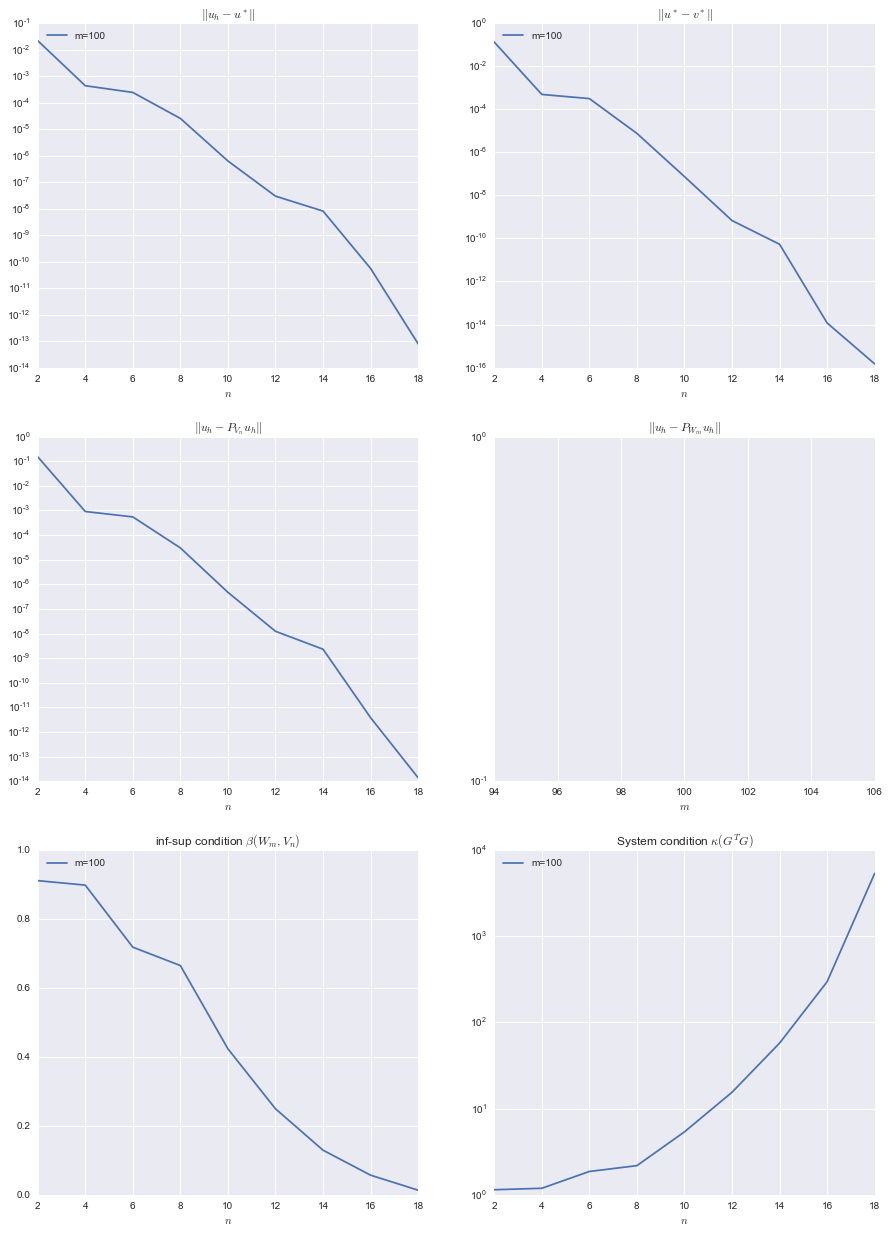

In [41]:
axs = []
fig = plt.figure(figsize=(15, 21))
axs.append(fig.add_subplot(3, 2, 1, title='$\| u_h - u^* \|$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 2, title='$\| u^* - v^* \|$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 3, title='$\| u_h - P_{V_n} u_h \|$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 4, title='$\| u_h - P_{W_m} u_h \|$'))
axs[-1].set(yscale="log", xlabel='$m$')
axs.append(fig.add_subplot(3, 2, 5, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 6, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')

for j, m in enumerate(ms):
    
    # If *not* nested use this code here:
    #Wm = df.make_random_local_integration_basis(m=m, div=fem_div, width=local_width, space='H1')
    #Wm = Wm.orthonormalise()
    
    Wm = Wbig.subspace(slice(0,m))
    
    # This is the measurement vector
    w = Wm.dot(fem_4.u)
    u_p_w = Wm.project(fem_4.u)

    m_stats[0, j] = (fem_4.u-u_p_w).norm(space='H1')
    
    ns = range(2, 19, 2)
    stats = np.zeros([5, len(ns)])
    for i, n in enumerate(ns):
    
        Vn = Vbig.subspace(slice(0,n))
        # If *not* nested use this code here:
        #Vn, V_fields = df.make_reduced_basis(n=n, field_div=2, fem_div=fem_div, space='H1')
        #Vn = Vn.orthonormalise()
        
        u_p_v = Vn.project(fem_4.u)
        
        BP = df.BasisPair(Wm, Vn)
        FB = BP.make_favorable_basis()
        
        u_star, v_star, w_p, v_w_p = FB.measure_and_reconstruct(fem_4.u)
        
        stats[0, i] = (fem_4.u-u_star).norm(space='H1')
        stats[1, i] = (u_star - v_star).norm(space='H1')
        stats[2, i] = FB.beta()
        stats[3, i] = np.linalg.cond(BP.G.T @ BP.G)
        stats[4, i] = (fem_4.u - u_p_v).norm(space='H1')
        
    axs[0].plot(ns, stats[0,:], label='m={0}'.format(m))
    axs[0].legend(loc=2)
    axs[1].plot(ns, stats[1,:], label='m={0}'.format(m))
    axs[1].legend(loc=2)
    axs[4].plot(ns, stats[2,:], label='m={0}'.format(m))
    axs[4].legend(loc=2)
    axs[5].plot(ns, stats[3,:], label='m={0}'.format(m))
    axs[5].legend(loc=2)

axs[2].plot(ns, stats[4,:], label='m={0}'.format(m))
axs[3].plot(ms, m_stats[0,:], label='m={0}'.format(m))
    
plt.show()

0.617995639236
0.0259736241589
